In [8]:
import sys
sys.path.append('../..')
import os
from tqdm import tqdm
from config import client
from pymongo import MongoClient
import pandas as pd
import torch
import matplotlib.pyplot as plt
import math
import numpy as np
from torch import nn, optim
import seaborn as sns

In [2]:
osu_db = client['osu_random_db']

In [4]:
#list of sample users' ids
cursor = osu_db["week_9_sample_users"].find({},{"users":1})
l = []
for el in cursor:
    l.append(el)
Ids = list(map(lambda x: x["users"], l))[0]
# print((Ids))



In [18]:
collection = osu_db["osu_scores_high"]
df1=pd.DataFrame(list(collection.find(
        {'enabled_mods':0,"user_id" : {"$in" : Ids}},{'maxcombo':True,'count50':True,'count100':True,'count300':True,
    'countmiss':True,'countgeki':True,'countkatu':True,'beatmap_id':True}
    )
))
df1

,_id,beatmap_id,maxcombo,count50,count100,count300,countmiss,countgeki,countkatu
0,13837747,110,140,7,41,216,3,13,17
1,13837087,194,133,0,5,87,0,22,4
2,28474531,207,103,2,26,180,11,97,19
3,7114604,279,71,0,5,40,0,20,5
4,7773047,280,77,3,19,75,2,17,9
...,...,...,...,...,...,...,...,...,...
154134,3393473811,1961156,75,27,81,261,27,19,22
154135,3395236149,2025939,45,6,29,89,6,14,12
154136,3394646326,2025943,41,5,27,70,8,7,13
154137,3393349709,2054309,79,3,27,130,5,19,17


In [28]:
# df1.describe()
list1 = list(df1['beatmap_id'])
# print(len(df1['beatmap_id'].unique()))

24804


In [8]:
collection2 = osu_db["osu_beatmaps"]
df2=pd.DataFrame(list(collection2.find(
        {"_id" : {"$in" : list1}}
    )
))
df2

NameError: name 'list1' is not defined

In [9]:
df = pd.DataFrame()
for user in Ids:
    for bm in df1[user]:
        bm.update(list(osu_db.osu_beatmaps.find( {"_id": bm["beatmap_id"]}, {"_id": 0, "countNormal": 1, "countSlider": 1, "countSpinner": 1, "countTotal": 1, "diff_approach": 1, "diff_drain": 1, "diff_overall": 1, "diff_size": 1, "diffcultyrating": 1, "hit_length": 1}))[0])
        bm.update(list(osu_db.osu_scores_high.find( {"user_id": user, "beatmap_id": bm["beatmap_id"], "enabled_mods": 0}, {"_id": 0, "mlpp.est_user_pp": 1}))[0]["mlpp"])
    df = df.append(pd.DataFrame(df1[user]))
df

KeyError: 756260

In [5]:
# copying from the other team

user_info = {}
for user in Ids:
    user_info[user] = list(osu_db.osu_scores_high.find( {"user_id": user, "enabled_mods": 0}, {"_id": 0, "beatmap_id": 1, "count50": 1, "count100": 1, "count300": 1, "countmiss": 1, "countgeki": 1, "countkatu": 1, "perfect": 1}))

In [6]:
user_info_with_beatmap_features = user_info
df = pd.DataFrame()
for user in Ids:
    for bm in user_info_with_beatmap_features[user]:
        bm.update(list(osu_db.osu_beatmaps.find( {"_id": bm["beatmap_id"]}, {"_id": 0, "countNormal": 1, "countSlider": 1, "countSpinner": 1, "countTotal": 1, "diff_approach": 1, "diff_drain": 1, "diff_overall": 1, "diff_size": 1, "diffcultyrating": 1, "hit_length": 1}))[0])
        bm.update(list(osu_db.osu_scores_high.find( {"user_id": user, "beatmap_id": bm["beatmap_id"], "enabled_mods": 0}, {"_id": 0, "mlpp.est_user_pp": 1}))[0]["mlpp"])
    df = df.append(pd.DataFrame(user_info_with_beatmap_features[user]))

In [7]:
df.drop(["beatmap_id"], axis = 1, inplace = True)

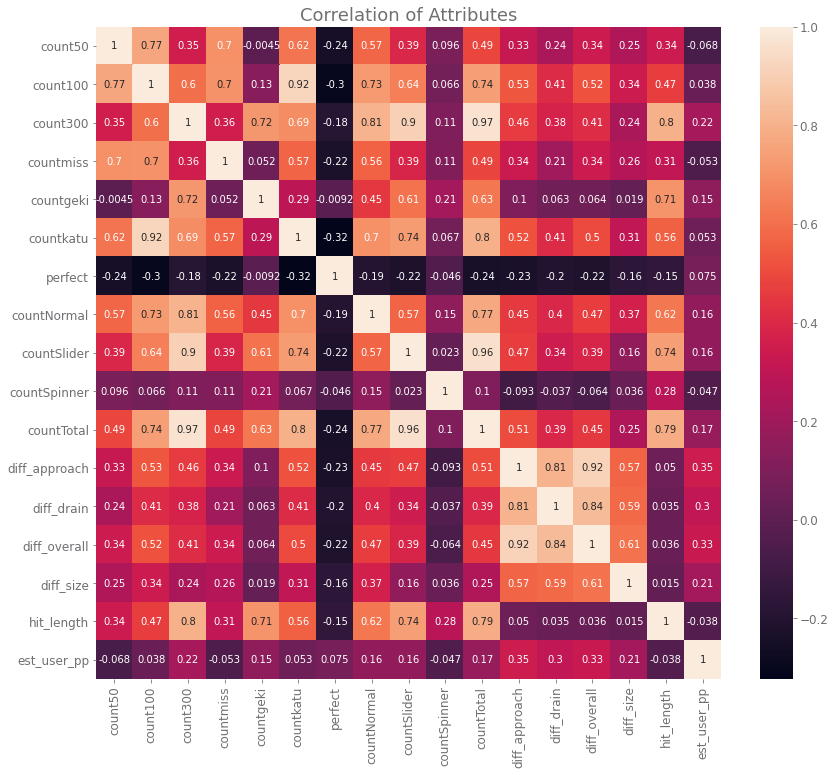

In [9]:
correlation = df.astype('float64').corr()
f, ax = plt.subplots(figsize = (14, 12))
plt.title("Correlation of Attributes")
sns.heatmap(correlation, annot = True)
plt.show()

In [36]:
# columns = ['beatmap_id', 'count50', 'count100', 'count300', 'countmiss',
      # 'countgeki', 'countkatu', 'perfect', 'countNormal', 'countSlider',
      # 'countSpinner', 'countTotal', 'diff_approach', 'diff_drain',
      # 'diff_overall', 'diff_size', 'hit_length', 'est_user_pp']

tensor = torch.tensor(df.values)

In [71]:
tensor = torch.reshape(tensor, (154139, 17, 1, 1))
print(tensor)

tensor([[[[  2.0000]],

         [[ 76.0000]],

         [[133.0000]],

         ...,

         [[  5.0000]],

         [[155.0000]],

         [[114.7568]]],


        [[[  6.0000]],

         [[ 24.0000]],

         [[ 70.0000]],

         ...,

         [[  5.0000]],

         [[ 64.0000]],

         [[132.5946]]],


        [[[  2.0000]],

         [[  7.0000]],

         [[185.0000]],

         ...,

         [[  3.0000]],

         [[209.0000]],

         [[ 63.0214]]],


        ...,


        [[[  0.0000]],

         [[ 12.0000]],

         [[156.0000]],

         ...,

         [[  3.0000]],

         [[ 77.0000]],

         [[ 44.2343]]],


        [[[  3.0000]],

         [[ 14.0000]],

         [[168.0000]],

         ...,

         [[  3.0000]],

         [[ 91.0000]],

         [[  7.9995]]],


        [[[  1.0000]],

         [[  8.0000]],

         [[ 72.0000]],

         ...,

         [[  3.0000]],

         [[ 80.0000]],

         [[ 10.5264]]]], dtype=torch.float64)

In [72]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(17, 154139, 1, 1)
      self.conv2 = nn.Conv2d(17, 154139, 1, 1)
      self.dropout1 = nn.Dropout2d(0.25)
      self.dropout2 = nn.Dropout2d(0.5)
      self.fc1 = nn.Linear(9216, 128)
      self.fc2 = nn.Linear(128, 10)

    # x represents our data
    def forward(self, x):
      # Pass data through conv1
      x = self.conv1(x)
      # Use the rectified-linear activation function over x
      x = F.relu(x)

      x = self.conv2(x)
      x = F.relu(x)

      # Run max pooling over x
      x = F.max_pool2d(x, 2)
      # Pass data through dropout1
      x = self.dropout1(x)
      # Flatten x with start_dim=1
      x = torch.flatten(x, 1)
      # Pass data through fc1
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout2(x)
      x = self.fc2(x)

      # Apply softmax to x
      output = F.log_softmax(x, dim=1)
      return output

In [73]:
data = tensor
my_nn = Net()
result = my_nn(data)

RuntimeError: [enforce fail at CPUAllocator.cpp:67] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 190070650568 bytes. Error code 12 (Cannot allocate memory)